In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import hanlp
import pickle
import collections
import keras
import pydot
import pydotplus
from pydotplus import graphviz
import time
import matplotlib.pyplot as plt
import jieba

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [2]:
def process_raw_data(file_path,label_cols,text_fea_cols,categorical_fea_cols,numeric_fea_cols,):
    df_raw = pd.read_csv(file_path, header=0, error_bad_lines=False, delimiter='\t', engine='python')    
    df_raw.fillna(value="",inplace=True)    
    df_no_user=df_raw.iloc[:,1:]
    
    '''for easy debug'''
    #df_no_user=df_no_user.head(3000)

    labels=df_no_user.iloc[:,label_cols]
    text_fea=df_no_user.iloc[:,text_fea_cols]
    categorical_fea=df_no_user.iloc[:,categorical_fea_cols]
    numeric_fea=df_no_user.iloc[:,numeric_fea_cols]
       
    return df_no_user,labels,text_fea,categorical_fea,numeric_fea
     

In [3]:
def process_categorical_fea(df,encoder_path):
    import pickle
    try:
        with open(encoder_path,'rb') as f:
            le=pickle.load(f)
            print("load encoder success!")
    except:
        le = LabelEncoder()
        print("construct a new encoder success!")
    
    with open(encoder_path,'wb') as handle:
        df_encode=df.apply(le.fit_transform)
        pickle.dump(le,handle)
        
    return df_encode

In [4]:
def process_numeric_fea(df):
    df.replace('',0,inplace=True)
    x = df.values
    '''Attention vs min_max_scale,使用min_max_scale会导致准确率大幅下降，因为min-max映射到[0-1],而standard不是'''
    std_scaler = preprocessing.StandardScaler() 
    x_scaled = std_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled,columns = df.columns.values)

In [5]:
def load_stop_words(filename):
    with open(filename,'r',encoding="utf-8") as f:
        stopwords_raw = f.readlines()
    return set([stop.strip() for stop in stopwords_raw])
    

def remove_stop_words(text,stopwords):
    text_without_stopwords = []
    for tokens in text:
        tokens_new=[]
        for t in tokens:
            if t not in stopwords:
                tokens_new.append(t)
        text_without_stopwords.append(tokens_new)
    return text_without_stopwords

def text_regex(text,
               regex='[a-zA-Z0-9’!"#$%&\'()*（）：；＋－+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~\s]+'):
    text_re=[]
    text_re=[re.sub(regex,"",t) for t in text]
    return text_re

def text_seg(text):   
    #tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)
    #text_seg=tok(text)
    text_seg=list()
    for tst in text:
        tst_seg=jieba.cut(tst)
        text_seg.append(" ".join(tst_seg))
    stopwords=load_stop_words("../config/stopwords.txt")
    #print("stopwords=",stopwords)
    text_seg=remove_stop_words(text_seg,stopwords)
    return text_seg

def get_tokenizer(path,text=None,num_words=5000): 
    
    try:
        with open(path, 'rb') as handle:
            tokenizer = pickle.load(handle)
    except:
        tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>',char_level=False)
        tokenizer.fit_on_texts(text)
    """
    比如
    num_words=1000，则说明，在输入的index值中，padding=0，oov=1，。。。。。max=999
    """
    print("tokenizer.num_words =",tokenizer.num_words)
    print("tokenizer.word_counts =",len(tokenizer.word_counts))
    print("tokenizer.word_index =",len(tokenizer.word_index))
    return tokenizer

def save_tokenizer(tokenizer,path):
    with open(path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
def process_text_fea(df,num_words=5000,token_path=None,max_len=50,text_matrix=False,matrix_mode='tfidf'):
    print("num_words=",num_words)
    if len(df.columns.values)!=1:
        raise Exception("df should has only one text type columns!")
    text=df.values.reshape(df.shape[0]).tolist()
    text=text_regex(text)
    text=text_seg(text)
    text_token=[]
    for text_ent in text:
        token_str=""
        for token in text_ent:
            token_str+=token+" "
        text_token.append(token_str.strip())
    
    tokenizer=get_tokenizer(path=token_path,text=text_token,num_words=num_words)
    '''为了防止不同版本的tokenizer混淆，暂时先不需要保存'''
    save_tokenizer(tokenizer,token_path)
    
    if text_matrix:
        text_sequence=tokenizer.texts_to_sequences(texts=text_token)
        text_sequence=tokenizer.sequences_to_matrix(sequences=text_sequence,mode=matrix_mode)
        print(type(text_sequence))
        print("text_sequence.shape=",text_sequence.shape)
    else:
        text_sequence=tokenizer.texts_to_sequences(texts=text_token)
        text_sequence=pad_sequences(sequences=text_sequence,padding="post",maxlen=max_len,truncating='pre')
        print(type(text_sequence))
        print("text_sequence.shape=",text_sequence.shape)
    
    text_sequence=np.asarray(text_sequence).tolist()
    
    return pd.DataFrame({df.columns.values[0]:text_sequence}),tokenizer

In [6]:
def get_label_and_feature(train_data,test_data,cost_label_col,recharge_label_col,text_fea_cols,categorical_fea_cols,numeric_fea_cols):
    
    train_cost_label=train_data[:,cost_label_col]
    train_recharge_label=train_data[:,recharge_label_col]
    train_text_fea=train_data[:,text_fea_cols]
    train_cate_fea=train_data[:,categorical_fea_cols] 
    train_numeric_fea=train_data[:,numeric_fea_cols]
    
    test_cost_label=test_data[:,cost_label_col]
    test_recharge_label=test_data[:,recharge_label_col]
    test_text_fea=test_data[:,text_fea_cols]
    test_cate_fea=test_data[:,categorical_fea_cols]
    test_numeric_fea=test_data[:,numeric_fea_cols]
    
    ##此处加上这个是为了解决：Failed to convert a NumPy array to a Tensor (Unsupported object type int).
    train_cost_label=np.asarray(train_cost_label).astype('int32')
    train_recharge_label=np.asarray(train_recharge_label).astype('int32')
    train_cate_fea=np.asarray(train_cate_fea).astype('int32')
    train_numeric_fea=np.asarray(train_numeric_fea).astype('float32') ##float not int !!
    
    '''
    单独处理train_text_fea，因为里面的元素是list，没法直接用上述方式转成int32
    '''
    train_text_fea=np.reshape(train_text_fea,(train_text_fea.shape[0],))
    train_text_fea_convert=[]
    for item in train_text_fea:
        train_text_fea_convert.append(np.asarray(item))
    train_text_fea=np.asarray(train_text_fea_convert).astype('int32')
           
    test_cost_label=np.asarray(test_cost_label).astype('int32')
    test_recharge_label=np.asarray(test_recharge_label).astype('int32')
    test_cate_fea=np.asarray(test_cate_fea).astype('int32')
    test_numeric_fea=np.asarray(test_numeric_fea).astype('float32') ##float not int !!
    
    '''
    单独处理test_text_fea，因为里面的元素是list，没法直接用上述方式转成int32
    '''
    test_text_fea=np.reshape(test_text_fea,(test_text_fea.shape[0],))
    test_text_fea_convert=[]
    for item in test_text_fea:
        test_text_fea_convert.append(np.asarray(item))
    test_text_fea=np.asarray(test_text_fea_convert).astype('int32')
    
    return train_cost_label,train_recharge_label,train_text_fea,train_cate_fea,train_numeric_fea,test_cost_label,test_recharge_label,test_text_fea,test_cate_fea,test_numeric_fea

    
    

In [7]:
def split_train_test_data(df,original=True,all_label_cols=None,label_col=None,label_values=None,label_counts=None,repeat_noise_ratio=0.95,sample_noise_ratio=0.95):
    
    print('-'*10+"label counts in all data"+'-'*10)   
    for lc in all_label_cols:
        print('label: ',lc)
        print(df_data.iloc[:,lc].value_counts())
          
    
    data=df.values  
    train_data,test_data=train_test_split(data,test_size=0.1)   
    
    if original==False:
        if len(label_values)!=len(label_counts):
            raise ValueError("list label_values'size isn't equal to list label_counts!")
        if len(np.unique(train_data[:,label_col]))!=len(label_counts):
            raise ValueError("df data dosen't has all label type!")
        
        print('-'*10+"label counts in train data BEFORE sample|repeat|noise"+'-'*10) 
        for lc in all_label_cols:
            print('label: ',lc)
            print(collections.Counter(train_data[:,lc]))
            
        train_data_dict={}
        for i in label_values:
            lv=label_values[i]
            lc=label_counts[i]
            #td=train_data[np.in1d(train_data[:, label_col], lv)]
            td=train_data[np.equal(train_data[:, label_col], lv)]
            td_other=train_data[np.not_equal(train_data[:, label_col], lv)]
            if td.shape[0]>=lc:
                print("label value=",lv," more than need! need=",lc," exist=",td.shape[0])
                noise_counts=math.ceil(lc*(1-sample_noise_ratio))
                noise_idxs=np.random.randint(td_other.shape[0],size=min(noise_counts,td_other.shape[0]))
                noise_td=td_other[noise_idxs,:]
                print("noise data counts=",noise_td.shape[0])
                noise_td[:,label_col]=lv
                               
                sample_counts=lc-noise_td.shape[0]
                sample_idxs=np.random.randint(td.shape[0],size=sample_counts)
                sample_td=td[sample_idxs,:]
                print("sample data counts=",sample_td.shape[0])
               
                merge_td=np.concatenate((sample_td,noise_td),axis=0)
                train_data_dict[lv]=np.asarray(merge_td)
            elif td.shape[0]<lc:
                print("label value=",lv," less than need! need=",lc," exist=",td.shape[0])
                lack_counts=lc-td.shape[0]
                print("lack_counts=",lack_counts)
                noise_counts=math.ceil(lack_counts*(1-repeat_noise_ratio))
                noise_idxs=np.random.randint(td_other.shape[0],size=noise_counts)
                noise_td=td_other[noise_idxs,:]
                print("noise data counts=",noise_td.shape[0])
                noise_td[:,label_col]=lv
                
                repeat_counts=lc-noise_counts
                repeat_times=math.ceil(repeat_counts/td.shape[0])
                repeat_td=np.repeat(td,repeat_times+2,axis=0)
                
                sample_idxs=np.random.randint(repeat_td.shape[0],size=repeat_counts)
                repeat_td=repeat_td[sample_idxs,:]
                print("repeat data counts=",repeat_td.shape[0])
                
                merge_td=np.concatenate((repeat_td,noise_td),axis=0)
                train_data_dict[lv]=np.asarray(merge_td)
                
        train_data=np.concatenate(list(train_data_dict.values()),axis=0)
        print('-'*10+"label counts in train data AFTER sample|repeat|noise"+'-'*10) 
        for lc in all_label_cols:
            print('label: ',lc)
            print(collections.Counter(train_data[:,lc]))
    
    print("train_data.shape=",train_data.shape)
    print('-'*10+"splited data counts"+'-'*10)   
    print('train:',train_data.shape)
    print('test:',test_data.shape)
    
    return train_data,test_data


In [8]:

def get_pre_trained_embedding(embedd_file):
    pre_trained_embed={}
    with open(embedd_file,'rb') as handle:
        next(handle)
        for line in handle:
            values = line.split()
            word = values[0].decode('utf-8')
            coefs = np.asarray(values[1:], dtype='float32')
            pre_trained_embed[word] = coefs
    
    words_size=len(pre_trained_embed)
    embed_size=len(pre_trained_embed[list(pre_trained_embed.keys())[0]])
    print(f"there are {words_size} words,every word has {embed_size} dimension")
    return pre_trained_embed


def init_embed_with_pre_trained(tokenizer,pre_trained_embed): 
    embed_size=len(pre_trained_embed[list(pre_trained_embed.keys())[0]])
    
    '''此处是voca_size好，还是num_words好，为了节约空间，还是使用num_words吧'''
    
    voca_size=len(tokenizer.word_index)+1
    embedding_matrix = np.zeros((voca_size, embed_size))
    
    #embedding_matrix = np.zeros((tokenizer.num_words, embed_size))
    
    hits=0
    miss=0
    for word, idx in tokenizer.word_index.items():
        embedding_vector = pre_trained_embed.get(word)
        if embedding_vector is not None:
            hits+=1
            embedding_matrix[idx] = embedding_vector
        else:
            miss+=1
    print("hits=",hits)
    print("miss=",miss)
    return embedding_matrix

def init_embed_with_pre_trained_2(tokenizer,pre_trained_embed): 
    embed_size=len(pre_trained_embed[list(pre_trained_embed.keys())[0]])
    
    '''此处是voca_size好，还是num_words好，为了节约空间，还是使用num_words吧'''
    
    #voca_size=len(tokenizer.word_index)+1
    #embedding_matrix = np.zeros((voca_size, embed_size))
    
    embedding_matrix = np.zeros((tokenizer.num_words, embed_size))
    
    hits=0
    miss=0
    effect_hits=0
    for word, idx in tokenizer.word_index.items():
        embedding_vector = pre_trained_embed.get(word)
        if embedding_vector is not None:
            hits+=1
            if idx<tokenizer.num_words:
                effect_hits+=1
                embedding_matrix[idx] = embedding_vector
        else:
            miss+=1
    print("hits=",hits)
    print("miss=",miss)
    print("effect_hits=",effect_hits)
    return embedding_matrix
    


In [9]:
def text_block_of_model(max_sequence_length,num_words,text_embed_size,lstm_size):
    inputs=tf.keras.layers.Input(shape=(max_sequence_length,),dtype=tf.int32,name='text_inputs')
    print("text embed's input size=",num_words)
    embed_outputs=tf.keras.layers.Embedding(input_dim=num_words, output_dim=text_embed_size, input_length=max_sequence_length,embeddings_initializer=tf.initializers.random_normal)(inputs)
    #lstm_outputs=Bidirectional(LSTM(lstm_size,activation="relu",dropout=0.2,return_sequences=True))(embed_outputs)
    lstm_outputs=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size,activation="relu",dropout=0.2,return_sequences=False))(embed_outputs)
    '''add batchnorm,to normlize the output for the same scale with numeric'''
    norm_outputs=tf.keras.layers.BatchNormalization()(lstm_outputs)
    return inputs,norm_outputs

def text_block_of_model_text_matrix(num_words=5000,dense_size=100):
    print("num_words=",num_words)
    inputs=tf.keras.layers.Input(shape=(num_words,),dtype=tf.float32,name='text_inputs')
    #print(inputs.shape)
    norm_outputs_1=tf.keras.layers.BatchNormalization()(inputs)
    dense_outputs=tf.keras.layers.Dense(dense_size, activation='sigmoid')(norm_outputs_1)
    norm_outputs_2=tf.keras.layers.BatchNormalization()(dense_outputs)
    return inputs,norm_outputs_2

def text_block_of_model_pre_trained(max_sequence_length,lstm_size,embedding_matrix):
    voca_size=embedding_matrix.shape[0] ##包括padding和oov，num_words,只是保证输入的index是【0，num_words-1】
    text_embed_size=embedding_matrix.shape[1]
    inputs=tf.keras.layers.Input(shape=(max_sequence_length,),dtype=tf.int32,name='text_inputs')
    print(f"voca_size={voca_size},text_embed_size={text_embed_size}")
    embed_outputs=tf.keras.layers.Embedding(input_dim=voca_size, output_dim=text_embed_size, input_length=max_sequence_length,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False)(inputs)
    #lstm_outputs=Bidirectional(LSTM(lstm_size,activation="relu",dropout=0.2,return_sequences=True))(embed_outputs)
    lstm_outputs=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_size,activation="relu",dropout=0.2,return_sequences=False))(embed_outputs)
    '''add batchnorm,to normlize the output for the same scale with numeric'''
    norm_outputs=tf.keras.layers.BatchNormalization()(lstm_outputs)
    return inputs,norm_outputs
    

In [10]:
def cate_block_of_model(cate_num_sizes,cate_embed_sizes):
    inputs=[]
    outputs=[]
    if len(cate_num_sizes)!=len(cate_embed_sizes):
        raise ValueError("cate size!= embed size!")
    for i in range(len(cate_num_sizes)):
        inpt = tf.keras.layers.Input(shape=(1,),dtype=tf.int32,name='cate_inputs_'+str(i))
        inputs.append(inpt)
        print("cate "+str(i)+" size:cate_num_sizes=",str(cate_num_sizes[i])+" ")
        embed = tf.keras.layers.Embedding(cate_num_sizes[i],cate_embed_sizes[i], trainable=True,embeddings_initializer=tf.initializers.random_normal)(inpt)
        embed_rehsaped =tf.keras.layers.Reshape(target_shape=(cate_embed_sizes[i],))(embed)
        outputs.append(embed_rehsaped)  
    concate_outputs=tf.keras.layers.concatenate(outputs)
    '''add batchnorm,to normlize the output for the same scale with numeric'''
    norm_outputs=tf.keras.layers.BatchNormalization()(concate_outputs)
    return inputs,norm_outputs


In [11]:
def numeric_block_of_model(input_size,dense_size):
    inputs=tf.keras.layers.Input(shape=(input_size,),dtype=tf.float32,name='numeric_inputs')
    dense_outputs=tf.keras.layers.Dense(dense_size, activation='relu')(inputs)
    norm_outputs=tf.keras.layers.BatchNormalization()(dense_outputs)
    return inputs,norm_outputs


In [12]:
def create_multi_task_learning_model(cate_num_sizes,cate_embed_sizes,
                                     numeric_input_size=200,numeric_dense_size=50,
                                     text_max_sequence_length=50,
                                     text_num_words=5000,
                                     text_embed_size=100,
                                     text_dense_size=40,
                                     text_lstm_size=20,
                                     text_matrix=False,
                                     is_pre_trained=False,
                                     inited_embedd_matrix=None):
    
    cate_inputs,cate_outputs=cate_block_of_model(cate_num_sizes,cate_embed_sizes)
    if text_matrix:
        text_inputs,text_outputs=text_block_of_model_text_matrix(num_words=text_num_words,dense_size=text_dense_size)  
    else:
        if is_pre_trained:
            text_inputs,text_outputs=text_block_of_model_pre_trained(max_sequence_length=text_max_sequence_length,lstm_size=text_lstm_size,embedding_matrix=inited_embedd_matrix)
        else:
            text_inputs,text_outputs=text_block_of_model(max_sequence_length=text_max_sequence_length,num_words=text_num_words,text_embed_size=text_embed_size,lstm_size=text_lstm_size)
        
    numeric_inputs,numeric_outputs=numeric_block_of_model(input_size=numeric_input_size,dense_size=numeric_dense_size)
    
    outputs=tf.keras.layers.concatenate([cate_outputs,text_outputs,numeric_outputs])
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    outputs=tf.keras.layers.Dense(60, activation='relu')(outputs)
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    
    outputs_cost=tf.keras.layers.Dense(20, activation='relu')(outputs)
    outputs_cost=tf.keras.layers.BatchNormalization()(outputs_cost)
    outputs_cost=tf.keras.layers.Dense(3, activation='softmax',name='outputs_cost')(outputs_cost)
    
    outputs_recharge=tf.keras.layers.Dense(20, activation='relu')(outputs)
    outputs_recharge=tf.keras.layers.BatchNormalization()(outputs_recharge)
    outputs_recharge=tf.keras.layers.Dense(3, activation='softmax',name='outputs_recharge')(outputs_recharge)
    
    model = Model(inputs=cate_inputs+[text_inputs,numeric_inputs], outputs=[outputs_cost,outputs_recharge])
    
    #model.summary()
    tf.keras.utils.plot_model(model, to_file=model_architecture_image,show_shapes=True,show_dtype=True,show_layer_activations=True)
    
    return model
        

In [13]:
def compile_multitask_model(model, gamma):
        
    model.compile(optimizer='adam',
                  loss={'outputs_cost': 'sparse_categorical_crossentropy', 
                        'outputs_recharge': 'sparse_categorical_crossentropy'},
                  loss_weights={'outputs_cost': gamma, 
                                'outputs_recharge': 1 - gamma}, 
                  metrics=['accuracy'])
        
    return model

In [22]:
def fit_batch(model):  
    start = time.time()
    history =model.fit(x={'cate_inputs_0': train_cate_fea[:,0],
                          'cate_inputs_1': train_cate_fea[:,1],
                          'cate_inputs_2': train_cate_fea[:,2],
                          'text_inputs': train_text_fea,
                          'numeric_inputs':train_numeric_fea},
                       y={'outputs_cost': train_cost_label,
                          'outputs_recharge': train_recharge_label},
                       validation_split=0.1,
                       epochs=10, 
                       batch_size=32, 
                       verbose=1)
    print(f'Training time: {time.time() - start}\n')
    return history


In [15]:
def plot_multitask_accuracies(training_history):
    
    plt.plot(range(len(history.history['outputs_cost_accuracy'])), history.history['outputs_cost_accuracy'], c='r', label='Cost')
    plt.plot(range(len(history.history['outputs_recharge_accuracy'])), history.history['outputs_recharge_accuracy'], c='b', label='Recharge')

    plt.plot(range(len(history.history['val_outputs_cost_accuracy'])), history.history['val_outputs_cost_accuracy'], c='r',linestyle='dashed', marker='o', label='Val-Cost')
    plt.plot(range(len(history.history['val_outputs_recharge_accuracy'])), history.history['val_outputs_recharge_accuracy'], c='b', linestyle='dashed', marker='o', label='Val-Recharge')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [16]:
def evaluate_score(y_true,y_pred_prob):
    pred_label=np.asarray([np.argmax(v) for v in y_pred_prob])
    print('accuracy: %.3f' % accuracy_score(y_true, pred_label))
    print('ovr macro auc: %.3f' % roc_auc_score(y_true, y_pred_prob,multi_class='ovo',average='macro')) #注意这里是prob
    print('ovo macro auc: %.3f' % roc_auc_score(y_true, y_pred_prob, multi_class='ovr',average='macro')) #注意这里是prob
    print('ovr weighted auc: %.3f' % roc_auc_score(y_true, y_pred_prob,multi_class='ovo',average='weighted')) #注意这里是prob
    print('ovo weighted auc: %.3f' % roc_auc_score(y_true, y_pred_prob, multi_class='ovr',average='weighted')) #注意这里是prob
    print('micro precision: %.3f' % precision_score(y_true, pred_label,average='micro'))
    print('macro precision: %.3f' % precision_score(y_true, pred_label,average='macro'))
    print('weighted precision: %.3f' % precision_score(y_true, pred_label,average='weighted'))
    print('micro recall: %.3f' % recall_score(y_true, pred_label,average='micro'))
    print('macro recall: %.3f' % recall_score(y_true, pred_label,average='macro'))
    print('weighted recall: %.3f' % recall_score(y_true, pred_label,average='weighted'))

In [17]:

print('*'*27+" Multi-Task-Model Begin Running "+'**'*27+"\n\n")

print('-'*40+" load data begin "+'-'*40)
label_cols=[0,1]
cost_label_col=0
recharge_label_col=1
text_fea_cols=[2]
categorical_fea_cols=[3,4,5]
numeric_fea_cols=list(range(6,271))
recharge_label_values=[0,1,2]

'''--tuning params--'''
recharge_label_counts=[30000,100000,600000]
is_raw=False
gamma_values=[0.5]
is_pre_trained=True
text_matrix=False
train_epochs=15
repeat_noise_ratio=1
sample_noise_ratio=1
num_words=4000
token_path="../tokenizer/tokenizer_4.2.3.online.pickle" #Attention,别跟别的模型乱了词表，所以此处要specific
max_sequence_len=30
data_file="../data/train_data_nlp_and_number_and_category_and_sentiments_feature_multi_label__extra_large.txt"
embedd_file="../pretrain_embedd/sgns.zhihu.word"
model_architecture_image='../model/model_4.2.3.online.png'
encoder_path="../category/cate_encoder_4.2.3.online.pickle"
'''--tuning params--'''

numeric_input_size=len(numeric_fea_cols)

df_no_user,labels,text_fea,categorical_fea,numeric_fea=process_raw_data(
    file_path=data_file,
    label_cols=label_cols,
    text_fea_cols=text_fea_cols,
    categorical_fea_cols=categorical_fea_cols,
    numeric_fea_cols=numeric_fea_cols
    )

print("df_no_user.shape=",df_no_user.shape)
print("labels.shape=",labels.shape)
print("text_fea.shape=",text_fea.shape)
print("categorical_fea.shape=",categorical_fea.shape)
print("numeric_fea.shape=",numeric_fea.shape)
print(df_no_user.head(1))
print('-'*40+" load data end "+'-'*40)

*************************** Multi-Task-Model Begin Running ******************************************************


---------------------------------------- load data begin ----------------------------------------
df_no_user.shape= (1000000, 271)
labels.shape= (1000000, 2)
text_fea.shape= (1000000, 1)
categorical_fea.shape= (1000000, 3)
numeric_fea.shape= (1000000, 265)
   c_label  r_label                                    problem_content  \
0        2        2  采购员客服发布招聘信息刷新优化#电话联系 设置采购 客服精品刷新 效果不好 建议客户多发帖#...   

   main_belong_loc1  main_belong_cate2 main_city_hierarchy  free_money_avg_1d  \
0              7578               3112                  二线                0.0   

   free_money_avg_3d  free_money_avg_7d  free_money_avg_14d  ...  \
0           0.002022           0.006067            0.013146  ...   

   m_login_counts_60d  sum_senti_score_latest_3month  \
0                   0                       1.184329   

   count_senti_score_latest_3mont  avg_score_latest_3month  \
0  

In [34]:
df_no_user['main_city_hierarchy'].value_counts()

三线     346548
二线     267099
四线     219389
五线      83190
新一线     73491
一线       4221
省直       3798
其他       2259
港澳台         5
Name: main_city_hierarchy, dtype: int64

In [32]:
print('-'*40+" process feature begin "+'-'*40)

df_text_token,tokenizer=process_text_fea(df=text_fea,num_words=num_words,token_path=token_path,max_len=max_sequence_len,text_matrix=text_matrix) 
df_categorical_fea_enc=process_categorical_fea(categorical_fea,encoder_path)
df_numeric_fea_scale=process_numeric_fea(numeric_fea)

df_data=pd.concat([labels,df_text_token,df_categorical_fea_enc,df_numeric_fea_scale],axis=1)
print(df_data.shape)
print(df_data.head(1))

if is_raw:
    train_data,test_data=split_train_test_data(df_data,all_label_cols=label_cols,original=True)
else:
    train_data,test_data=split_train_test_data(df_data,all_label_cols=label_cols,original=False,
                                               label_col=recharge_label_col,label_values=recharge_label_values,label_counts=recharge_label_counts,
                                               repeat_noise_ratio=repeat_noise_ratio,sample_noise_ratio=sample_noise_ratio)

print('-'*40+" process feature end "+'-'*40)

---------------------------------------- process feature begin ----------------------------------------
num_words= 4000
tokenizer.num_words = 4000
tokenizer.word_counts = 3542
tokenizer.word_index = 3543
<class 'numpy.ndarray'>
text_sequence.shape= (1000000, 30)
load encoder success!
(1000000, 271)
   c_label  r_label                                    problem_content  \
0        2        2  [31, 720, 304, 2, 125, 70, 68, 41, 17, 83, 85,...   

   main_belong_loc1  main_belong_cate2  main_city_hierarchy  \
0               444                135                    2   

   free_money_avg_1d  free_money_avg_3d  free_money_avg_7d  \
0           -0.14997          -0.221571          -0.296424   

   free_money_avg_14d  ...  m_login_counts_60d  sum_senti_score_latest_3month  \
0           -0.380058  ...           -0.020562                       -0.40815   

   count_senti_score_latest_3mont  avg_score_latest_3month  \
0                       -0.147302                -0.464747   

   sum_sent

In [19]:
print('-'*40+" process pretrained embedding begin "+'-'*40)
pre_trained_embed=get_pre_trained_embedding(embedd_file=embedd_file)
inited_embedd_matrix=init_embed_with_pre_trained_2(tokenizer=tokenizer,pre_trained_embed=pre_trained_embed)
print("inited_embedd_matrix.shape=",inited_embedd_matrix.shape)
print('-'*40+" process pretrained embedding end "+'-'*40)

---------------------------------------- process pretrained embedding begin ----------------------------------------
there are 259869 words,every word has 300 dimension
hits= 3434
miss= 109
effect_hits= 3434
inited_embedd_matrix.shape= (4000, 300)
---------------------------------------- process pretrained embedding end ----------------------------------------


In [20]:
print('-'*40+" process label and feature begin "+'-'*40)
train_cost_label,train_recharge_label,train_text_fea,train_cate_fea,train_numeric_fea,test_cost_label,test_recharge_label,test_text_fea,test_cate_fea,test_numeric_fea=get_label_and_feature(
    train_data,test_data,
    cost_label_col,recharge_label_col,
    text_fea_cols,categorical_fea_cols,numeric_fea_cols)

print("train_cost_label.shape=",train_cost_label.shape)
print("train_recharge_label.shape=",train_recharge_label.shape)
print("train_text_fea.shape=",train_text_fea.shape)
print("train_cate_fea.shape=",train_cate_fea.shape)
print("train_numeric_fea.shape=",train_numeric_fea.shape)

print("test_cost_label.shape=",test_cost_label.shape)
print("test_recharge_label.shape=",test_recharge_label.shape)
print("test_text_fea.shape=",test_text_fea.shape)
print("test_cate_fea.shape=",test_cate_fea.shape)
print("test_numeric_fea.shape=",test_numeric_fea.shape)

print('-'*40+" process label and feature end "+'-'*40)


---------------------------------------- process label and feature begin ----------------------------------------
train_cost_label.shape= (730000,)
train_recharge_label.shape= (730000,)
train_text_fea.shape= (730000, 30)
train_cate_fea.shape= (730000, 3)
train_numeric_fea.shape= (730000, 265)
test_cost_label.shape= (100000,)
test_recharge_label.shape= (100000,)
test_text_fea.shape= (100000, 30)
test_cate_fea.shape= (100000, 3)
test_numeric_fea.shape= (100000, 265)
---------------------------------------- process label and feature end ----------------------------------------


In [ ]:

print('-'*40+" train model begin "+'-'*40)

cate_num_sizes=[]
cate_embed_sizes=[]
for c in categorical_fea_cols:
    cs=train_data[:,c].max()+1 #attention +1 begin because from zero!!!    
    cate_num_sizes.append(cs)
    cate_embed_sizes.append(math.ceil(cs/20)+2)

trained_models=list()
training_histories=list()
predict_results=list()
for i in range(len(gamma_values)):
    print(f"train model for gamma={gamma_values[i]}")
    
    model=create_multi_task_learning_model(cate_num_sizes=cate_num_sizes,
                                           cate_embed_sizes=cate_embed_sizes,
                                           text_max_sequence_length=max_sequence_len,
                                           text_num_words=num_words,
                                           text_embed_size=100,
                                           text_dense_size=40,
                                           text_lstm_size=20,
                                           numeric_input_size=numeric_input_size,
                                           numeric_dense_size=50,
                                           text_matrix=text_matrix,
                                           is_pre_trained=is_pre_trained,
                                           inited_embedd_matrix=inited_embedd_matrix)
    compile_multitask_model(model,gamma_values[i])
    history=fit_batch(model)

    pred_result=model.predict(x={'cate_inputs_0': test_cate_fea[:,0],
                                    'cate_inputs_1': test_cate_fea[:,1],
                                    'cate_inputs_2': test_cate_fea[:,2],
                                    'text_inputs': test_text_fea,
                                    'numeric_inputs':test_numeric_fea}
                                 ,verbose=1,use_multiprocessing=True)
    trained_models.append(model)
    training_histories.append(history)
    predict_results.append(pred_result)
    
print('-'*40+" train model end "+'-'*40)

      

---------------------------------------- train model begin ----------------------------------------
train model for gamma=0.5
cate 0 size:cate_num_sizes= 666 
cate 1 size:cate_num_sizes= 181 
cate 2 size:cate_num_sizes= 9 
voca_size=4000,text_embed_size=300
Epoch 1/10
20532/20532 [==============================] - 527s 25ms/step - loss: 0.5781 - outputs_cost_loss: 0.7338 - outputs_recharge_loss: 0.4224 - outputs_cost_accuracy: 0.6904 - outputs_recharge_accuracy: 0.8473 - val_loss: 0.3967 - val_outputs_cost_loss: 0.6551 - val_outputs_recharge_loss: 0.1383 - val_outputs_cost_accuracy: 0.7344 - val_outputs_recharge_accuracy: 0.9757
Epoch 2/10
19826/20532 [===========================>..] - ETA: 17s - loss: 0.5426 - outputs_cost_loss: 0.7022 - outputs_recharge_loss: 0.3830 - outputs_cost_accuracy: 0.7052 - outputs_recharge_accuracy: 0.8580

---------------------------------------- plot and evaluate begin ----------------------------------------
plot for gamma=0.5


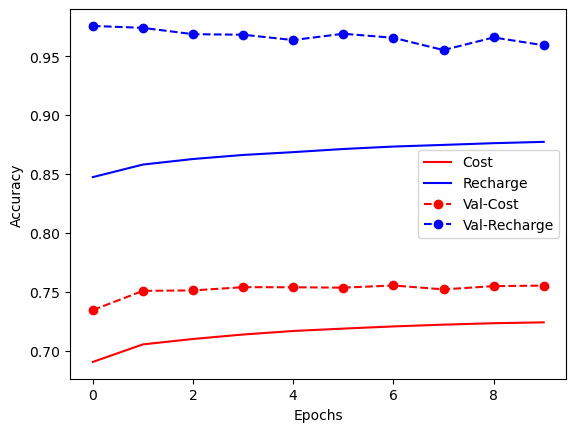

-----------消耗模型评估分值: ---------
accuracy: 0.743
ovr macro auc: 0.784
ovo macro auc: 0.815
ovr weighted auc: 0.811
ovo weighted auc: 0.824
micro precision: 0.743
macro precision: 0.637
weighted precision: 0.713
micro recall: 0.743
macro recall: 0.552
weighted recall: 0.743
-----------充值模型评估分值: ---------
accuracy: 0.938
ovr macro auc: 0.827
ovo macro auc: 0.873
ovr weighted auc: 0.869
ovo weighted auc: 0.873
micro precision: 0.938
macro precision: 0.464
weighted precision: 0.957
micro recall: 0.938
macro recall: 0.549
weighted recall: 0.938
---------------------------------------- plot and evaluate end ----------------------------------------


In [24]:
print('-'*40+" plot and evaluate begin "+'-'*40)
for i in range(len(gamma_values)):
    
    print(f"plot for gamma={gamma_values[i]}")
    plot_multitask_accuracies(training_histories[i])

    pred_result=np.asarray(predict_results[i])
    predict_prob_cost=pred_result[0]
    predict_prob_recharge=pred_result[1]
    print("-----------消耗模型评估分值: ---------")
    evaluate_score(test_cost_label,predict_prob_cost)
    print("-----------充值模型评估分值: ---------")
    evaluate_score(test_recharge_label,predict_prob_recharge)

print('-'*40+" plot and evaluate end "+'-'*40)


In [25]:
print(len(trained_models))
trained_models[0].save("../model/4.2.3.online/")

1


2023-03-14 11:09:40.841721: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model/4.2.3/assets


In [26]:
model_online = keras.models.load_model('../model/4.2.3.online/')

In [29]:
pred_result_online=model_online.predict(x={'cate_inputs_0': test_cate_fea[:,0],
                                    'cate_inputs_1': test_cate_fea[:,1],
                                    'cate_inputs_2': test_cate_fea[:,2],
                                    'text_inputs': test_text_fea,
                                    'numeric_inputs':test_numeric_fea}
                                 ,verbose=1,use_multiprocessing=True)

3125/3125 [==============================] - 18s 6ms/step


In [30]:
predict_prob_cost_online=pred_result_online[0]
predict_prob_recharge_online=pred_result_online[1]
print("-----------消耗模型评估分值: ---------")
evaluate_score(test_cost_label,predict_prob_cost_online)
print("-----------充值模型评估分值: ---------")
evaluate_score(test_recharge_label,predict_prob_recharge_online)

-----------消耗模型评估分值: ---------
accuracy: 0.743
ovr macro auc: 0.784
ovo macro auc: 0.815
ovr weighted auc: 0.811
ovo weighted auc: 0.824
micro precision: 0.743
macro precision: 0.637
weighted precision: 0.713
micro recall: 0.743
macro recall: 0.552
weighted recall: 0.743
-----------充值模型评估分值: ---------
accuracy: 0.938
ovr macro auc: 0.827
ovo macro auc: 0.873
ovr weighted auc: 0.869
ovo weighted auc: 0.873
micro precision: 0.938
macro precision: 0.464
weighted precision: 0.957
micro recall: 0.938
macro recall: 0.549
weighted recall: 0.938
